In [24]:
import numpy as np
import csv
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [3]:
def round_to_quarter(score):
    """Làm tròn điểm đến .0, .25, .5, hoặc .75."""
    return np.round(score * 4) / 4

In [6]:

def generate_student_data(num_students, config):
    """Tạo dữ liệu điểm cho sinh viên."""
    data = []

    component_weights = np.array([cfg['weight']
                                 for cfg in config['components']])

    for _ in range(num_students):
        student_scores = []
        # Tạo điểm thành phần
        for comp_cfg in config['components']:
            score = np.random.uniform(
                comp_cfg['min_range'], comp_cfg['max_range'])
            score = round_to_quarter(np.clip(score, 0, 10))
            student_scores.append(score)

        # Tính điểm trung bình có trọng số làm cơ sở cho điểm thi
        weighted_avg = np.sum(np.array(student_scores) *
                              component_weights) / np.sum(component_weights)

        # Tạo điểm thi cuối kỳ dựa trên điểm thành phần
        # Điểm trung bình càng cao, tâm phân phối điểm thi càng cao
        # Thêm nhiễu để tạo sự ngẫu nhiên, nhưng giữ xu hướng
        # Có thể điều chỉnh khoảng nhiễu
        exam_mean = weighted_avg + np.random.uniform(-1, 1)

        # Tạo điểm thi với xu hướng, nhưng thêm ngẫu nhiên lớn hơn
        # Sử dụng phân phối tam giác: thấp, trung bình (mode), cao
        # Mode càng cao khi weighted_avg càng cao
        mode = np.clip(exam_mean, 0, 10)
        # Tăng/giảm khoảng để điều chỉnh độ phân tán
        low = np.clip(mode - 2, 0, 10)
        high = np.clip(mode + 2, 0, 10)

        final_exam_score = np.random.triangular(low, mode, high)
        final_exam_score = round_to_quarter(np.clip(final_exam_score, 0, 10))

        student_scores.append(final_exam_score)
        data.append(student_scores)

    return data


def save_to_csv(data, filename="student_scores.csv"):
    """Lưu dữ liệu vào file CSV."""
    header = ['C1', 'C2', 'C3',
              'C4', 'FinalExam']
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(data)
    print(f"Đã lưu dữ liệu vào file '{filename}'")


# --- Cấu hình ---
NUM_STUDENTS = 5000  # Số lượng sinh viên cần tạo

# Cấu hình cho từng đầu điểm thành phần
# weight: trọng số (dùng để tính điểm cơ sở cho điểm thi)
# min_range, max_range: khoảng random cho điểm.
# Các đầu điểm 10% (ví dụ Component1, Component2) có thể có khoảng cao hơn.
SCORE_CONFIG = {
    'components': [
        {'name': 'C1', 'weight': 0.10,
            'min_range': 6.0, 'max_range': 10.0},
        {'name': 'C2', 'weight': 0.10,
            'min_range': 6.0, 'max_range': 10.0},
        {'name': 'C3', 'weight': 0.10, 'min_range': 2.0, 'max_range': 10.0},
        {'name': 'C4', 'weight': 0.20, 'min_range': 2.0, 'max_range': 10.0},
    ]
}
# Lưu ý: Trọng số ở đây chỉ dùng để tính 'xu hướng' cho điểm thi cuối kỳ,
# không nhất thiết phải tổng = 1.

# --- Chạy chương trình ---
if __name__ == "__main__":
    student_data = generate_student_data(NUM_STUDENTS, SCORE_CONFIG)
    save_to_csv(student_data)

    print("\n5 dòng dữ liệu đầu tiên:")
    for row in student_data[:5]:
        print(row)

Đã lưu dữ liệu vào file 'student_scores.csv'

5 dòng dữ liệu đầu tiên:
[8.0, 6.25, 7.75, 3.75, 6.0]
[9.5, 9.25, 6.0, 2.5, 7.75]
[9.5, 8.5, 7.25, 3.0, 5.25]
[7.75, 10.0, 8.75, 8.5, 8.25]
[6.25, 6.0, 7.0, 3.0, 5.0]


In [7]:
# --- 1. Tải và Chuẩn bị Dữ liệu ---
CSV_FILENAME = "student_scores.csv"  # Sử dụng file dữ liệu gốc
MODEL_FILENAME = "student_score_predictor_cnn.h5"  # Tên file để lưu model

df = pd.read_csv(CSV_FILENAME)

# Xác định các cột đặc trưng (input) và cột mục tiêu (output)
feature_columns = ['C1', 'C2', 'C3', 'C4']
target_column = 'FinalExam'

X_original = df[feature_columns].values
y = df[target_column].values

print(f"\nSố lượng mẫu dữ liệu: {len(X_original)}")
print(f"Hình dạng của X_original (trước khi áp dụng trọng số): {X_original.shape}")
print(f"Hình dạng của y: {y.shape}")

# --- ÁP DỤNG TRỌNG SỐ CHO ĐẦU ĐIỂM THÀNH PHẦN (INPUT FEATURES) ---
# Định nghĩa trọng số cho từng cột điểm C1 đến C4.
input_feature_weights = np.array([0.1, 0.1, 0.1, 0.2])
X_weighted = X_original * input_feature_weights


# Định hình dữ liệu X_weighted cho CNN: (samples, timesteps, features)
X_cnn = X_weighted.reshape((X_weighted.shape[0], X_weighted.shape[1], 1))
print(f"Hình dạng của X_cnn (sau khi reshape): {X_cnn.shape}")



Số lượng mẫu dữ liệu: 5000
Hình dạng của X_original (trước khi áp dụng trọng số): (5000, 4)
Hình dạng của y: (5000,)
Hình dạng của X_cnn (sau khi reshape): (5000, 4, 1)


In [27]:
# --- 2. Xây dựng Mô hình CNN ---
model = Sequential([
    InputLayer(input_shape=(X_cnn.shape[1], X_cnn.shape[2])),  # (4, 1)
    Conv1D(filters=32, kernel_size=2, activation='relu', padding='causal'),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(1)
])

model.summary()

# --- 3. Biên dịch Mô hình ---
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 4, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,177 (8.50 KB)

 Trainable params: 2,177 (8.50 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
EPOCHS = 100
BATCH_SIZE = 16
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_cnn, y,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[early_stopping])
model.save(MODEL_FILENAME)

Epoch 1/100


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - loss: 23.2413 - mae: 4.0477 - val_loss: 1.1422 - val_mae: 0.8817
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 1.1003 - mae: 0.8530 - val_loss: 1.0106 - val_mae: 0.8316
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 0.9590 - mae: 0.7849 - val_loss: 0.9535 - val_mae: 0.8078
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.9475 - mae: 0.7815 - val_loss: 0.9390 - val_mae: 0.7978
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.9332 - mae: 0.7796 - val_loss: 0.9461 - val_mae: 0.8040
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.9362 - mae: 0.7837 - val_loss: 0.9666 - val_mae: 0.8139
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.9674 - mae: 0.7993 - val_loss: 0.9331 - val_mae: 0.7955
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.9429 - mae: 0.7861 - val_loss: 0.9318 - val_mae: 0.7942
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s

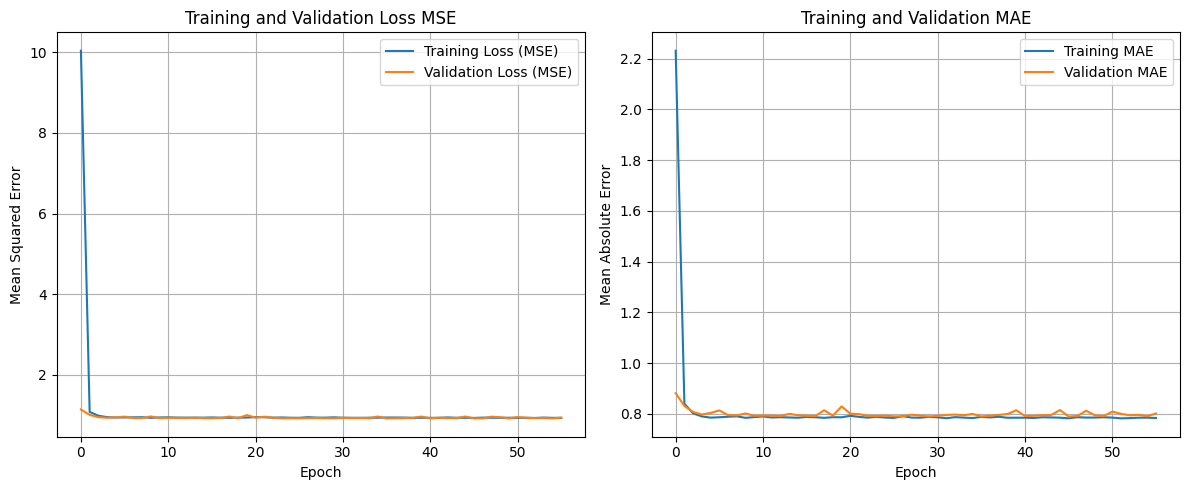

In [29]:
# --- 6. Vẽ Biểu đồ Lịch sử Huấn luyện ---
if history is not None:
    plt.figure(figsize=(12, 5))

    # Biểu đồ Loss (MSE)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss (MSE)')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.title('Training and Validation Loss MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)

    # Biểu đồ MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    if 'val_mae' in history.history:
        plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [41]:
# --- 7. Dự đoán thử và Đánh giá ---
num_predictions = 10
X_sample_cnn = X_cnn[:num_predictions]
y_sample_actual = y[:num_predictions]

predicted_scores = model.predict(X_sample_cnn)

print(f"\n--- Kết quả dự đoán cho {num_predictions} mẫu đầu tiên ---")
print("Điểm thực tế  | Điểm dự đoán")
print("---------------------------------")
for i in range(num_predictions):
    print(f"{y_sample_actual[i]:<14.2f} | {predicted_scores[i][0]:<14.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

--- Kết quả dự đoán cho 10 mẫu đầu tiên ---
Điểm thực tế  | Điểm dự đoán
---------------------------------
6.00           | 6.01          
7.75           | 6.05          
5.25           | 6.35          
8.25           | 8.63          
5.00           | 5.20          
6.75           | 7.46          
8.50           | 7.27          
5.25           | 5.46          
5.75           | 5.40          
6.75           | 7.70          
